# Zebra page separation A/B Test Analysis 7: 
# Deepdive by browser type
__Jennifer Wang, Staff Data Scientist, Wikimedia Foundation__

July 2023

## TICKETS:
Instumentation planning : 
- Spec: [T333222](https://phabricator.wikimedia.org/T333222)

Instrumentation deployment :  
- Launch AB test: [T335972](https://phabricator.wikimedia.org/T335972)
- Fix bug: [T336969](https://phabricator.wikimedia.org/T336969)

Data tickets:
- Data QA: [T336299](https://phabricator.wikimedia.org/T336299)
- __Analysis: [T335379](https://phabricator.wikimedia.org/T335379)__

# Introduction

The Wikimedia Foundation's Web team is exploring a new page separation in vector-2022 skin. The current Vector 2022 interface uses whitespace to separate the various regions and has a white page background. The proposed new page interface uses gray background  to separate the various regions. The team hope the new layout separation will help users focus on the content and reduce the eye strain experienced by some individuals.  

To evaluate the impact of introducing the new page separation , an AB test was conducted on the desktop logged-in users with vector-2022 skin between May 29,2023 and Jun 20, 2023. The experiment only took place on the following test wikis:  hewiki, enwiki, fawiki, frwiki, kowiki, ptwiki, srwiki, thwiki, trwiki, viwiki.


__The default Vector-2022 layout with a white background__    
<img src="Figures/default_layout.png" width="800" height="600" align="center" style="border: 5px solid LightSteelBlue" />    
__The new layout (Zebra) with a gray background outside of the content area__.     
<img src="Figures/zebra_layout.png" width="800" height="600" align="center" style="border: 5px solid LightSteelBlue" />     

# Purpose

The primary goal of the AB Test was to test two hypothesis:
1. There is no significant change on pageviews with the new layout separation.
2. There is no significant change on edits with the new layout separation.

We also sought to answer three curiosity questions:
1. Does it impact the usage of TOC as the new layout separated ToC and content into different boxes?
2. Does it impact the usage of Page tools? (Number of pins or unpins)
3. Does it impact the scrolling to top behavior? (Nice to have)

This report focuses on the above metrics __broken down by browser type__.

# Methodology

The AB test was run on a per wiki basis on logged-in users with Vector-2022 skin. Users included in the test were randomly assigned to either the control (default) or treatment (new page separation) based on their local user ID.

We reviewed AB test data recorded from 02 Jun 2023 through 19 Jun 2023 for this analysis. Data was limited to pageviews and edits completed by desktop logged-in users who were selected in the AB test.

We compared the numbers of each metric between control and treatment groups broken down by top 10 browser families.

Note that we excluded data collected from May 29 2023  to June 1 2023 in this analysis due to a bug which caused the edit button to be missing on the sticky header.

In [8]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [9]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [14]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Query data or import data

As discovered in QA [T336299](https://phabricator.wikimedia.org/T336299), we should 
1) exclude sessions which were assigned to both control group and treatment group. They constitute 0.12% of total sessions. 
2) exclude 466 sessions from bot users.

In [3]:
query_pageviews <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') 
AND year=2023 AND month=6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')  
AND year=2023  AND month=6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
AND NOT is_bot
AND NOT is_anon
AND skin='vector-2022'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- pageviews from ab test group
SELECT  t3.event.token AS session_id, t3.event.pageToken AS page_token, 
t3.wiki, t3.event.editCountBucket,  t4.test_group, 
user_agent_map['browser_family'] AS browser,
count(1) AS pvs
FROM event.DesktopWebUIActionsTracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')
AND t3.year=2023 and t3.month=6
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND t4.session_dt <= t3.meta.dt
AND NOT event.isanon 
AND event.action='init' AND event.skin='vector-2022'
GROUP BY  t3.event.token ,t3.event.pageToken, t3.wiki, t3.event.editCountBucket,  
t4.test_group , user_agent_map['browser_family'] 
"

In [4]:
df_pageviews <- wmfdata::query_hive(query_pageviews)

Don't forget to authenticate with Kerberos using kinit



In [5]:
dim(df_pageviews)

[1] 19921367        7

In [15]:
df_pvs_browser_per_session <- df_pageviews %>%
   group_by(wiki,test_group, session_id, browser) %>%
   summarize(sum_pvs=sum(pvs),n_pages=n_distinct(page_token), .groups='drop')

In [17]:
dim(df_pvs_browser_per_session)

[1] 1109600       6

# Data exploration

In [18]:
summary(df_pvs_browser_per_session)

     wiki            test_group         session_id          browser         
 Length:1109600     Length:1109600     Length:1109600     Length:1109600    
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
    sum_pvs            n_pages        
 Min.   :    1.00   Min.   :    1.00  
 1st Qu.:    1.00   1st Qu.:    1.00  
 Median :    4.00   Median :    4.00  
 Mean   :   17.96   Mean   :   17.95  
 3rd Qu.:   11.00   3rd Qu.:   11.00  
 Max.   :31002.00   Max.   :31002.00  

# Analysis


## Pageviews 

In [19]:
df_pvs_browser_per_session %>% 
  group_by(session_id) %>%
  summarize(n_dup=n_distinct(browser), .groups='drop') %>%
  filter(n_dup>1) %>% 
  nrow()

[1] 2775

In [2]:
2775/1106811

[1] 0.002507203

2775 sessions (0.25% of total sessions) switched browser during AB test. 

In [23]:
df_pvs_browser_per_session %>% 
   filter(session_id=='000a0c9d011d6088d0a7')

wiki,test_group,session_id,browser,sum_pvs,n_pages
<chr>,<chr>,<chr>,<chr>,<int>,<int>
enwiki,treatment,000a0c9d011d6088d0a7,Chrome,7,7
enwiki,treatment,000a0c9d011d6088d0a7,Edge,3,3


### Note 
Surprisly, the session id survived across browser. According to https://gerrit.wikimedia.org/r/plugins/gitiles/schemas/event/secondary/+/refs/heads/master/jsonschema/analytics/legacy/desktopwebuiactionstracking/current.yaml

token:
            description: >-
              Session token that survives across pages (mw.user.sessionId()),
              but not when browser restarts.


In [29]:
df_pvs_browser_overall <- df_pvs_browser_per_session %>%
   group_by(test_group, browser ) %>%
   summarize(total_pvs=sum(sum_pvs),total_pv_pages=sum(n_pages), n_sessions=n_distinct(session_id), .groups='drop') %>%
   mutate(pvs_per_sessions = round(total_pvs/n_sessions,2))

In [32]:
df_pvs_browser_overall %>% 
  filter(n_sessions>1000)

test_group,browser,total_pvs,total_pv_pages,n_sessions,pvs_per_sessions
<chr>,<chr>,<int>,<int>,<int>,<dbl>
control,Chrome,6073790,6072686,330581,18.37
control,Chrome Mobile,150464,150328,11796,12.76
control,Chrome Mobile iOS,29072,29072,2528,11.50
control,Edge,1226832,1226683,63421,19.34
control,Firefox,1285679,1285677,61567,20.88
control,HeadlessChrome,33137,33137,33073,1.00
control,Mobile Safari,122622,122622,8507,14.41
control,Opera,168277,168235,4286,39.26
control,Safari,870803,870803,49012,17.77


In [33]:
df_pvs_browser_overall  %>% 
 filter(browser=='HeadlessChrome')

test_group,browser,total_pvs,total_pv_pages,n_sessions,pvs_per_sessions
<chr>,<chr>,<int>,<int>,<int>,<dbl>
control,HeadlessChrome,33137,33137,33073,1
treatment,HeadlessChrome,1,1,1,1


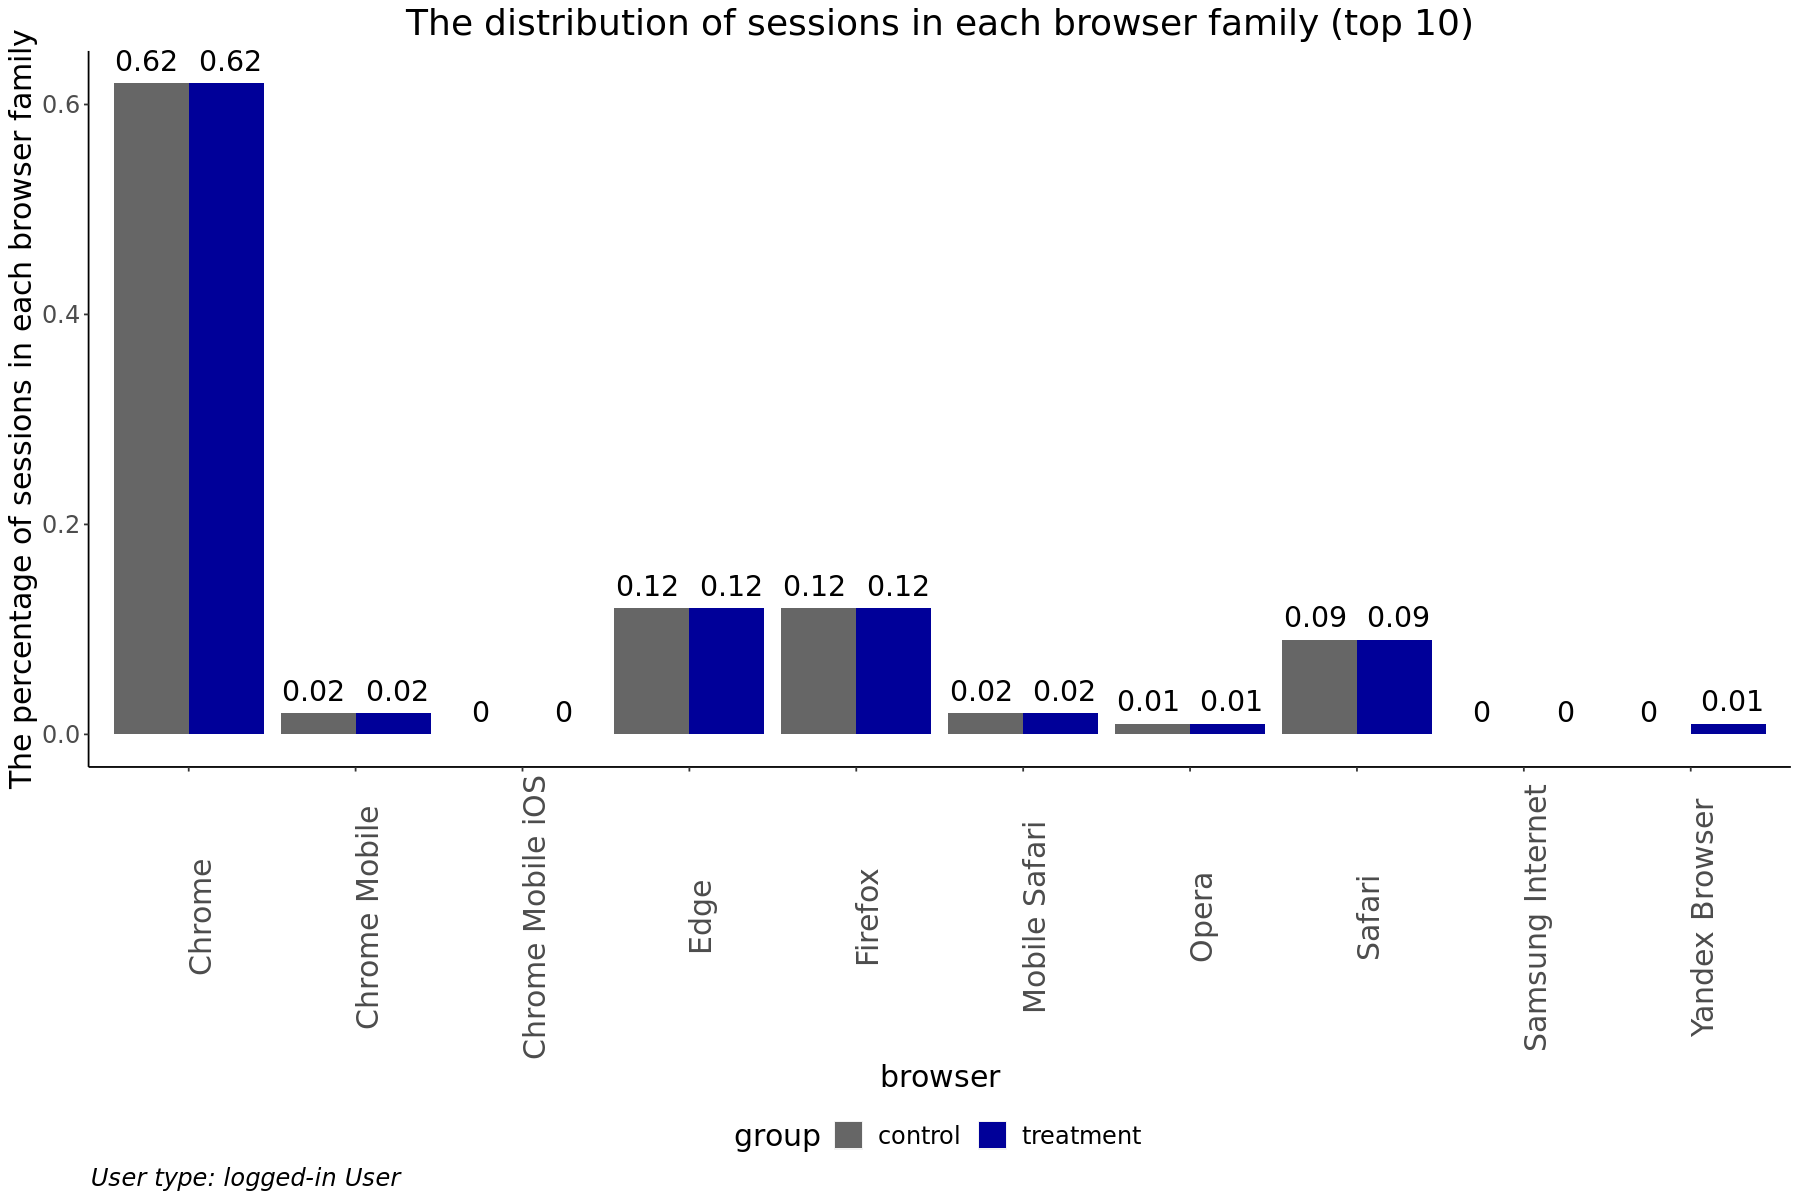

In [40]:
barchart_sessions_viewsizebucket_overall <- df_pvs_browser_overall  %>% 
  filter(n_sessions>1000) %>%
 filter(browser!='HeadlessChrome') %>%
  group_by(test_group) %>%
  mutate(
      ptg=round(n_sessions/sum(n_sessions),2)
      ) %>% 
  ggplot(aes(x = browser, y= ptg, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(ptg)), color = "black", position = position_dodge(width = 1), 
                  vjust = -0.6, hjust = 0.5, size = 6) +
        labs (
              y = "The percentage of sessions in each browser family" ,
             title = "The distribution of sessions in each browser family (top 10)" ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_viewsizebucket_overall

### Note 

Bucketing by browser is balanced.
Above figure shows the distribution of the reader sessions by top 10 browsers. Majority of readers use Chrome browser.


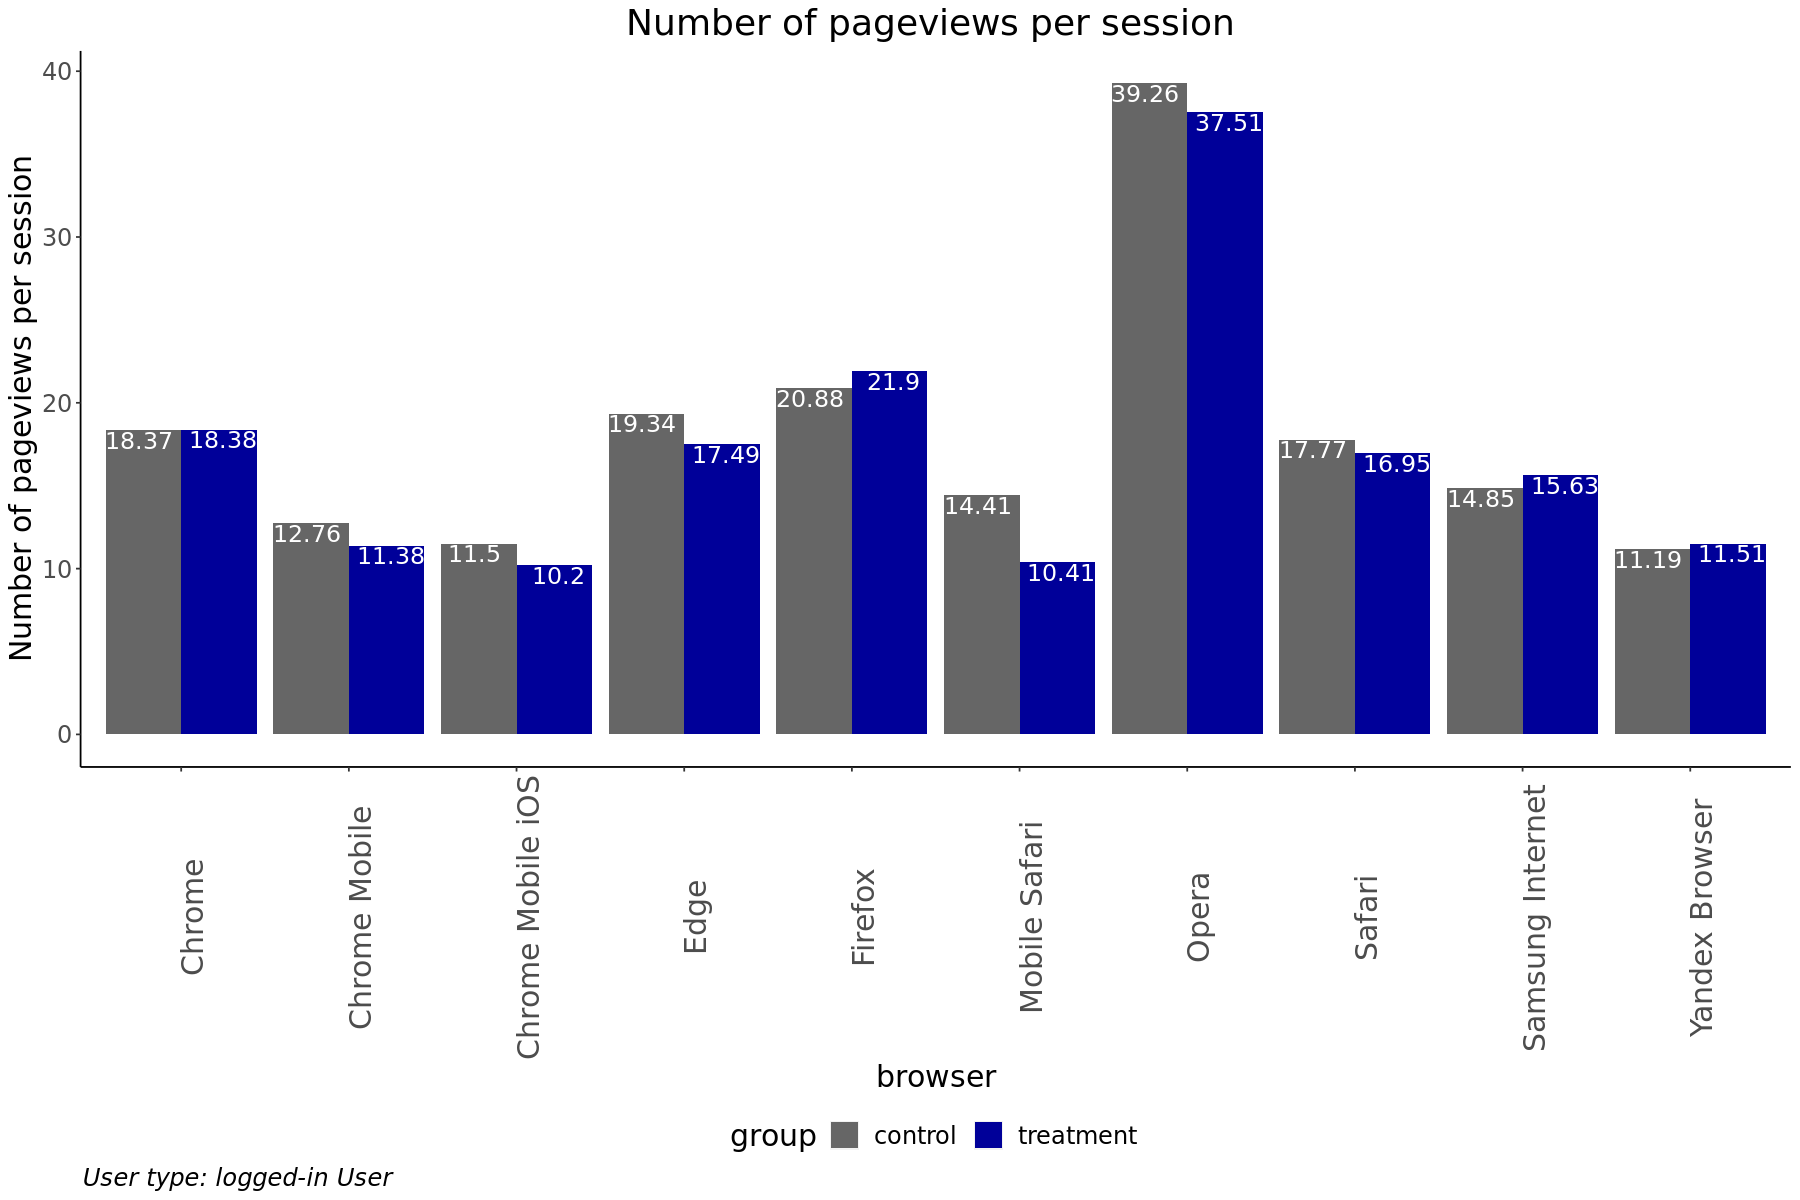

In [69]:
barchart_pvs_browser_overall  <- df_pvs_browser_overall  %>%
         filter(n_sessions>1000) %>%
      filter(browser!='HeadlessChrome') %>%
        select(browser, test_group, pvs_per_sessions) %>%
        ggplot(aes(x = browser, y= pvs_per_sessions, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(pvs_per_sessions)), color = "white", position = position_dodge(width = 1), 
                  vjust = 1.1, hjust = 0.5, size = 5) +
        labs (
              y = "Number of pageviews per session" ,
             title = "Number of pageviews per session " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_pvs_browser_overall 

### Note 
When broken down by browser family, it was observed that the treatment group exhibited an decrease in page views per session in all mobile browsers.

It also decreased on Edge and Opera. 

## Edits (clicks on edit button) 

In [43]:
query_edit_clicks <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') 
AND year=2023 AND month=6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')  
AND year=2023  and month=6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
AND NOT is_bot
AND NOT is_anon
AND skin='vector-2022'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- clicks on edit button from ab test group
SELECT  t3.event.token AS session_id, t3.event.pageToken AS page_token,
t3.wiki,   t4.test_group,  t3.user_agent_map['browser_family']  as browser,
count(1) AS edit_clicks
FROM event.desktopwebuiactionstracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')
AND t3.year=2023 and t3.month=6
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND t4.session_dt <= t3.meta.dt
AND NOT event.isanon 
AND event.action='click' 
AND event.name IN ('ca-edit','ca-ve-edit')
AND event.skin='vector-2022'
GROUP BY  t3.event.token ,  t3.event.pageToken,  t3.wiki, t4.test_group , t3.user_agent_map['browser_family'] 
"


In [44]:
df_edit_clicks <- wmfdata::query_hive(query_edit_clicks)

Don't forget to authenticate with Kerberos using kinit



In [49]:
df_edits_browser_per_session <- df_edit_clicks  %>%
   group_by(wiki,test_group, session_id, browser) %>%
   summarize(sum_edits=sum(edit_clicks),n_pages=n_distinct(page_token), .groups='drop')

In [60]:
df_edits_browser_overall <- df_edits_browser_per_session %>%
   group_by(test_group, browser ) %>%
   summarize(total_edits=sum(sum_edits),total_pages=sum(n_pages), n_sessions=n_distinct(session_id), .groups='drop') %>%
   mutate(edits_per_sessions = round(total_edits/n_sessions,2))

In [61]:
df_edits_browser_overall %>%
          filter(n_sessions>100) %>%
      filter(browser!='HeadlessChrome') 

test_group,browser,total_edits,total_pages,n_sessions,edits_per_sessions
<chr>,<chr>,<int>,<int>,<int>,<dbl>
control,Chrome,180682,162586,34137,5.29
control,Chrome Mobile,4531,4074,1410,3.21
control,Chrome Mobile iOS,479,436,175,2.74
control,Edge,35584,33226,6277,5.67
control,Firefox,35224,32303,6819,5.17
control,Mobile Safari,2718,2553,844,3.22
control,Opera,4717,4002,541,8.72
control,Safari,26643,23911,4851,5.49
control,Samsung Internet,345,329,123,2.80


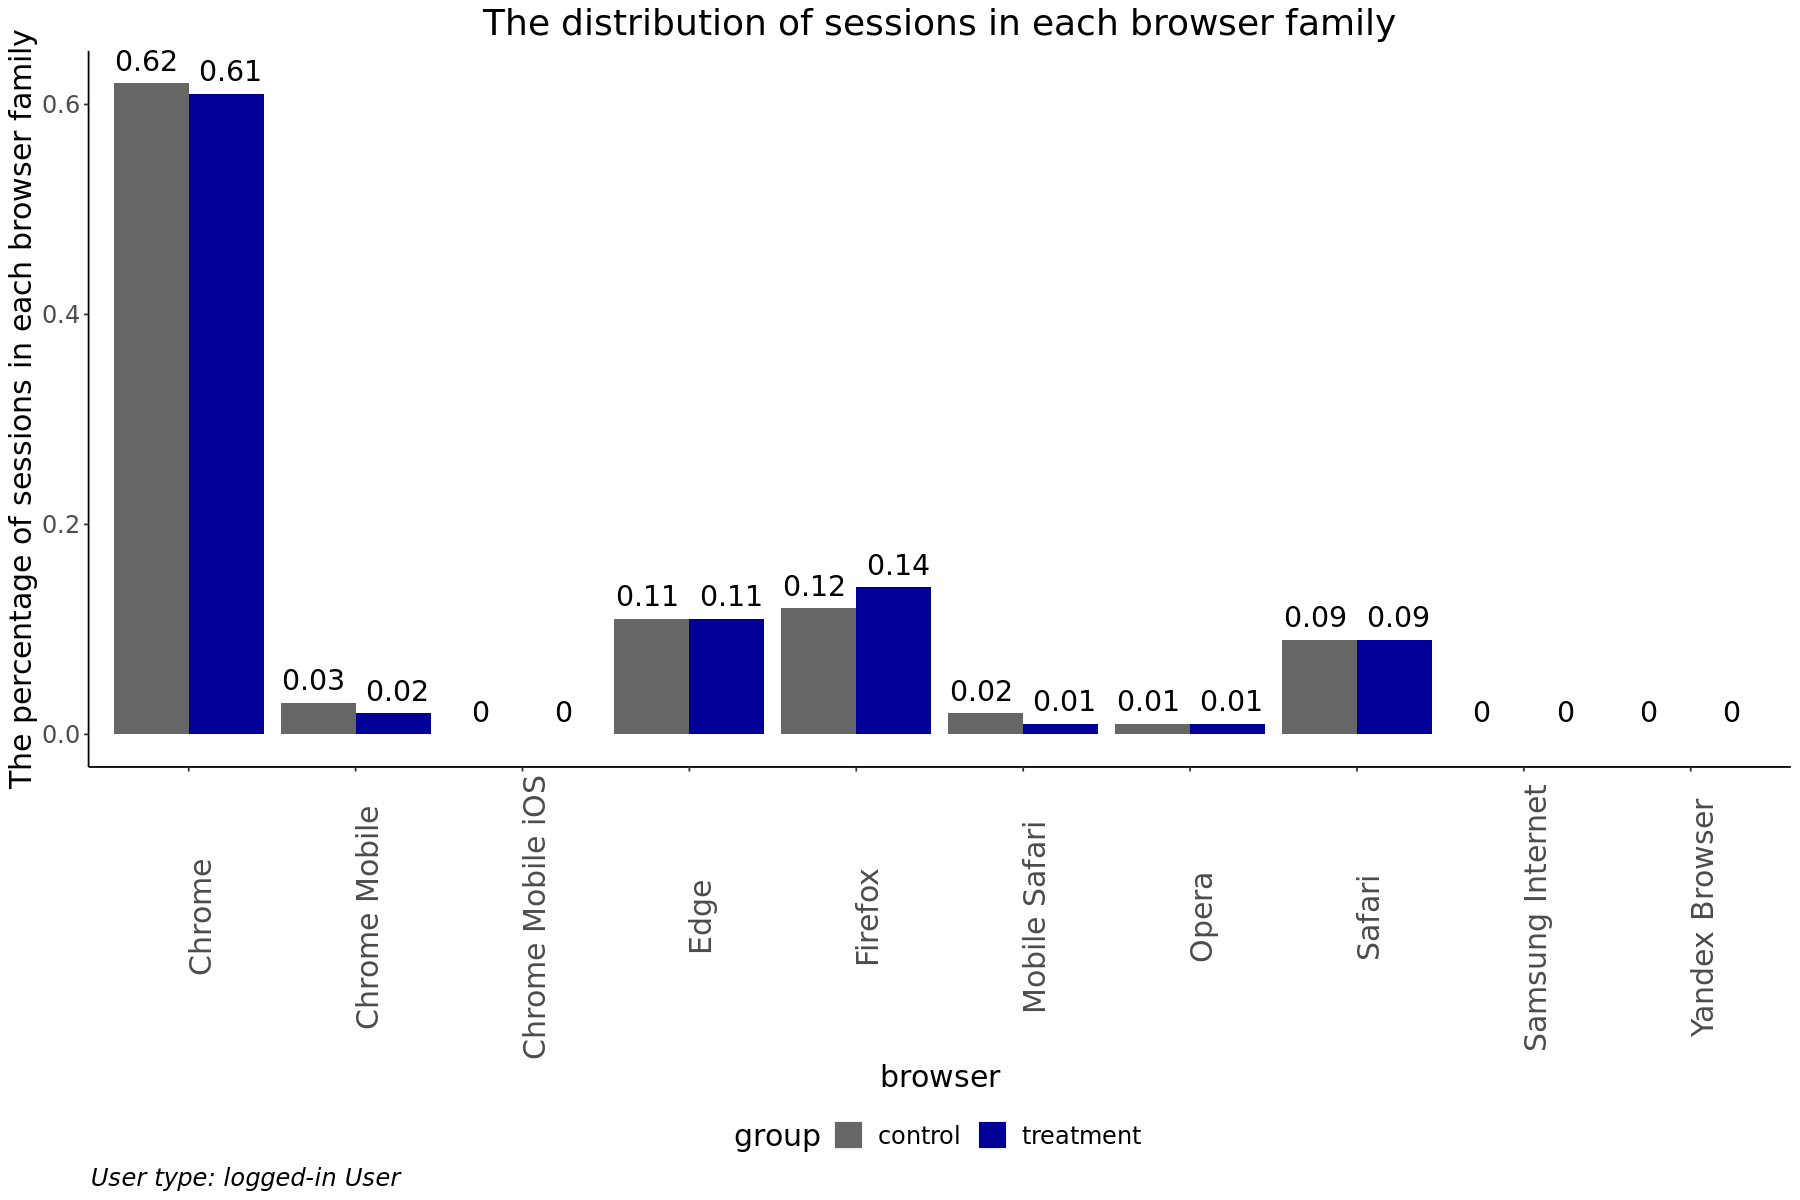

In [64]:
barchart_sessions_browser_overall <- df_edits_browser_overall  %>%
      filter(n_sessions>100) %>%
      filter(browser!='HeadlessChrome')%>%
  group_by(test_group) %>%
  mutate(
      ptg=round(n_sessions/sum(n_sessions),2)
      ) %>% 
  ggplot(aes(x = browser, y= ptg, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(ptg)), color = "black", position = position_dodge(width = 1), 
                  vjust = -0.6, hjust = 0.5, size = 6) +
        labs (
              y = "The percentage of sessions in each browser family" ,
             title = "The distribution of sessions in each browser family" ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_browser_overall

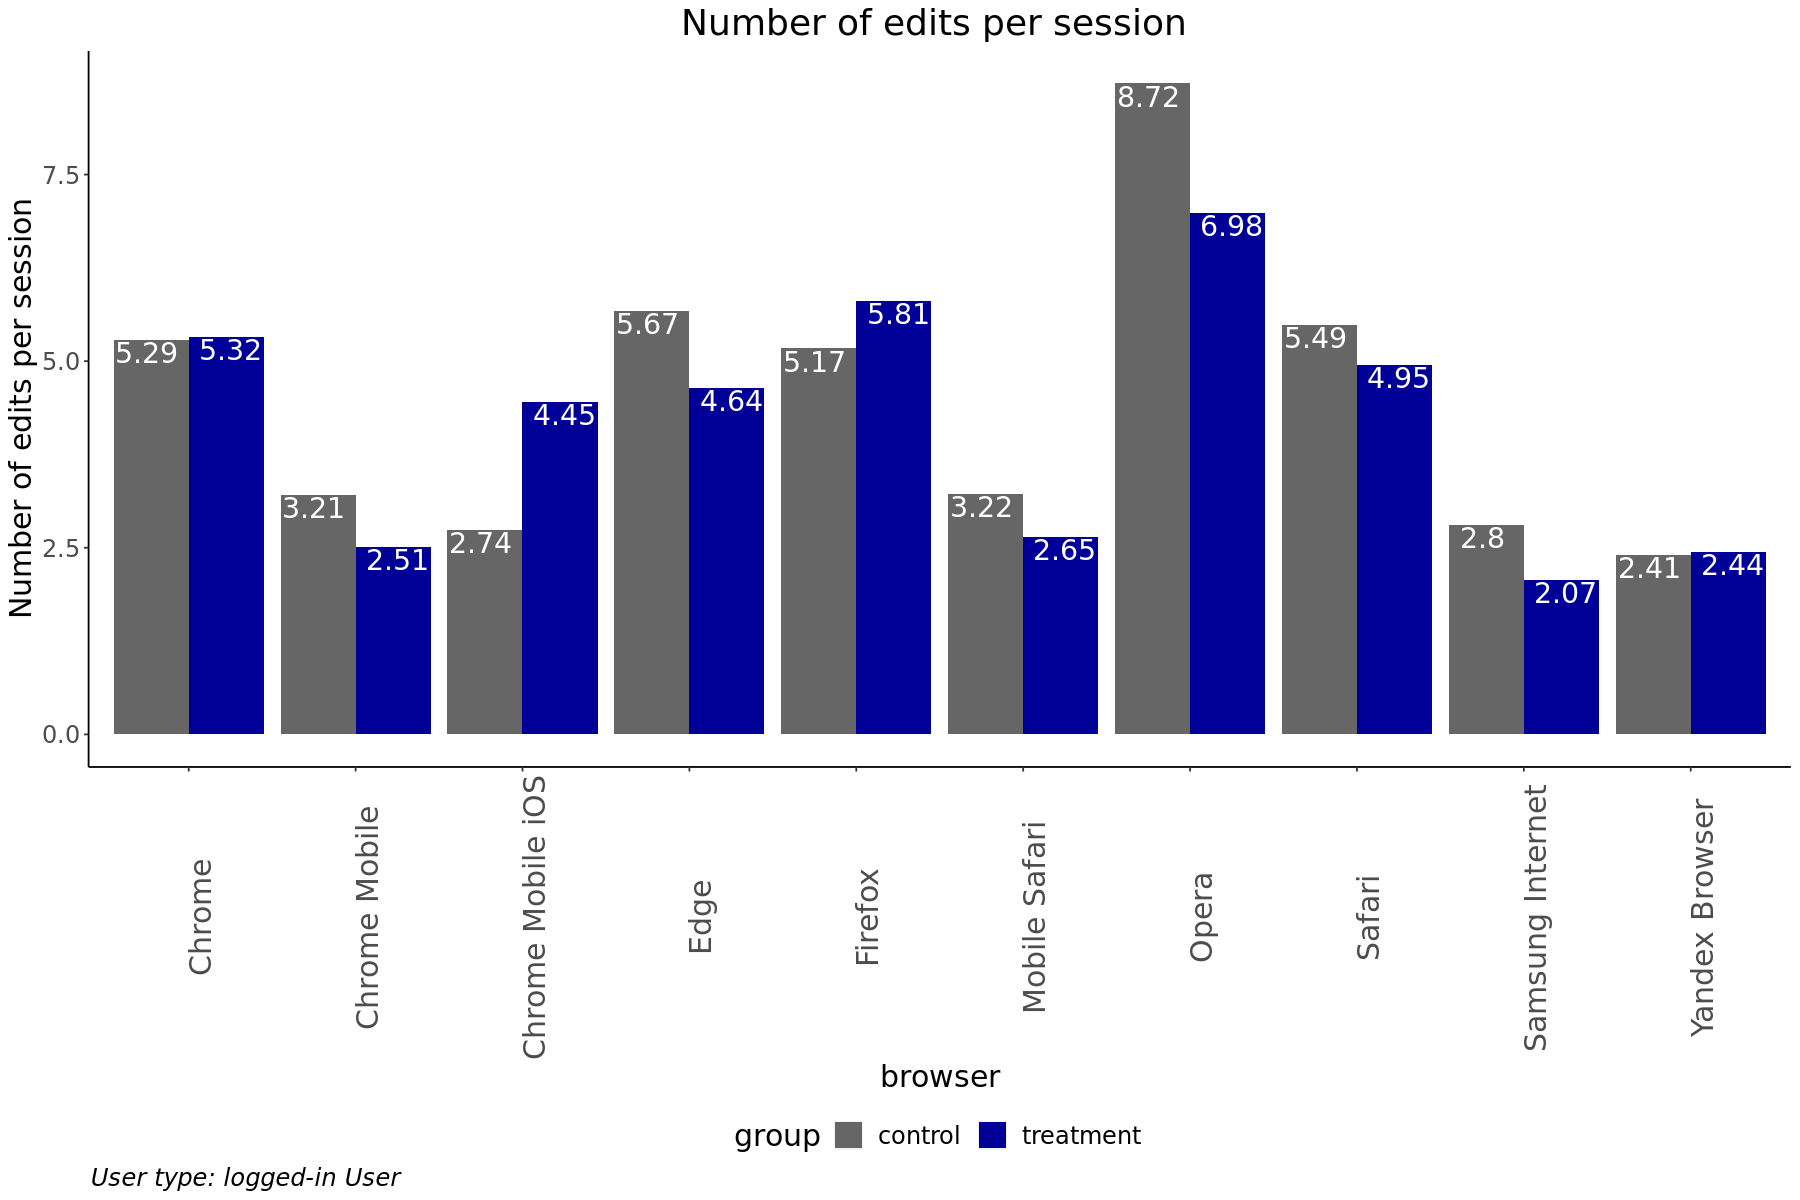

In [67]:
barchart_edits_browser_overall  <- df_edits_browser_overall  %>%
      filter(n_sessions>100) %>%
      filter(browser!='HeadlessChrome')%>%
   ggplot(aes(x = browser, y= edits_per_sessions, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(edits_per_sessions)), color = "white", position = position_dodge(width = 1), 
                  vjust = 1.1, hjust = 0.5, size = 6) +
        labs (
              y = "Number of edits per session" ,
             title = "Number of edits per session " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_edits_browser_overall

### Note
Edits per session decreased on Chrome Mobile, Edge, Mobile Safari, Opera, Safari and Samsung Internet.

Edits per session increased on Chrome Mobile iOS, Firefox.